In [1]:
import os
import sys
sys.path.append( os.path.abspath("../../workspace/python-work/python 3/cs230_deeplearning_implement/ec_code/")  )
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from class4.week1.assignment.cnn_utils import *

%matplotlib inline
np.random.seed(1)

y = 2
number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


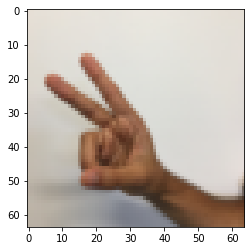

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))


X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

In [3]:
# GRADED FUNCTION: create_placeholders
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    n_y -- scalar, number of classes
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X=tf.placeholder(name="X",shape=(None,n_H0,n_W0,n_C0),dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=(None, n_y), dtype=tf.float32)
    return X, Y


# GRADED FUNCTION: initialize_parameters
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]   8=nameber of filters
                        W2 : [2, 2, 8, 16]
    parameters -- a dictionary of tensors containing W1, W2
    """
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    W1=tf.get_variable(name='W1', dtype=tf.float32, shape=(4, 4, 3, 8), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2=tf.get_variable(name='W2', dtype=tf.float32, shape=(2, 2, 8, 16), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    parameters={"W1": W1, "W2": W2}
    return parameters



# GRADED FUNCTION: forward_propagation
def forward_propagation(X, parameters):
    """
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1=parameters['W1']
    W2=parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1=tf.nn.conv2d(input=X,filter=W1,strides=[1,1,1,1],padding="SAME")
    # RELU
    A1=tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1=tf.nn.max_pool(value=A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2=tf.nn.conv2d(input=P1, filter=W2, strides=(1, 1, 1, 1), padding='SAME')
    # RELU
    A2=tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2=tf.nn.max_pool(value=A2, ksize=(1, 4, 4, 1), strides=(1, 4, 4, 1), padding='SAME')
    # FLATTEN
    P=tf.contrib.layers.flatten(inputs=P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
     #全连接层（FC）：使用没有非线性激活函数的全连接层
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3=tf.contrib.layers.fully_connected(P, 6, activation_fn=None)
    return Z3



# GRADED FUNCTION: compute_cost 
def compute_cost(Z3, Y):
    """
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost



In [4]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y=create_placeholders(n_H0, n_W0, n_C0, n_y)
    # Initialize parameters
    parameters=initialize_parameters()
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3=forward_propagation(X, parameters)
    # Cost function: Add cost function to tensorflow graph
    cost=compute_cost(Z3, Y)
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init=tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                #=======================important=====================================
                #=======================important=====================================
                #=======================important=====================================
                _ , temp_cost=sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost+=temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
    
    



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Cost after epoch 0: 1.921332


Cost after epoch 5: 1.904156


Cost after epoch 10: 1.904309


Cost after epoch 15: 1.904477


Cost after epoch 20: 1.901876


Cost after epoch 25: 1.784078


Cost after epoch 30: 1.681052


Cost after epoch 35: 1.618207


Cost after epoch 40: 1.597972


Cost after epoch 45: 1.566707


Cost after epoch 50: 1.554486


Cost after epoch 55: 1.502187


Cost after epoch 60: 1.461035


Cost after epoch 65: 1.304477


Cost after epoch 70: 1.201501


Cost after epoch 75: 1.144229


Cost after epoch 80: 1.098368


Cost after epoch 85: 1.093381


Cost after epoch 90: 1.040853


Cost after epoch 95: 1.032087


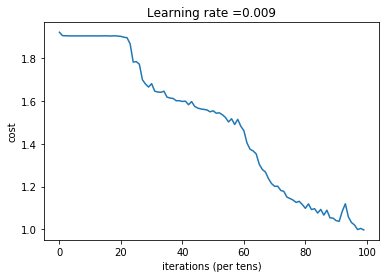

Tensor("Mean_1:0", shape=(), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[1080,8,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-3-ebd4dfa90a63>:45) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-4-0e15c9eb0c66>:76) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-ddfc1f084c11>", line 1, in <module>
    _, _, parameters = model(X_train, Y_train, X_test, Y_test)
  File "<ipython-input-4-0e15c9eb0c66>", line 29, in model
    Z3=forward_propagation(X, parameters)
  File "<ipython-input-3-ebd4dfa90a63>", line 45, in forward_propagation
    Z1=tf.nn.conv2d(input=X,filter=W1,strides=[1,1,1,1],padding="SAME")
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\software_installed_cs\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1080,8,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-3-ebd4dfa90a63>:45) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-4-0e15c9eb0c66>:76) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [5]:
    _, _, parameters = model(X_train, Y_train, X_test, Y_test)